In [1]:
import re
import os
import glob
import doppyo
import itertools
import regionmask
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# Notebook specific -----
%matplotlib inline

In [2]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(cores=1,
                       memory='8GB',
                       walltime='03:00:00')
cluster

/flush4/squ027/miniconda3/envs/pangeo/lib/python3.6/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/flush4/squ027/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


In [3]:
from dask.distributed import Client
client = Client(cluster)

In [4]:
saveloc = '/OSM/CBR/OA_DCFP/work/squ027/squire_scratch/projects/HydroTAS/c2_remote_drivers/figures/'

# Load the c2 control run (sst and slp)

In [5]:
path = '/OSM/CBR/OA_DCFP/data2/model_output/CAFE/controls/c2b/OUTPUT/'
files = sorted(glob.glob(path + 'ocean_month*'))
sst = xr.open_mfdataset(files[5:], use_cftime=True, parallel=True)['temp'].isel(st_ocean=0, drop=True) \
        .rename({'xt_ocean':'lon','yt_ocean':'lat'}).resample(time='MS').mean('time')

files = sorted(glob.glob(path + 'atmos_month*'))
slp = xr.open_mfdataset(files[5:], use_cftime=True, parallel=True)['slp'].resample(time='MS').mean('time')

files = sorted(glob.glob(path + 'atmos_daily*plevel.nc'))
precip = xr.open_mfdataset(files[5:], use_cftime=True, parallel=True)['precip'].resample(time='MS').mean('time')

# Compute anomalies

In [6]:
sst_anom = (sst.groupby('time.month') - sst.groupby('time.month').mean('time')).drop('month')
slp_anom = (slp.groupby('time.month') - slp.groupby('time.month').mean('time')).drop('month')
precip_anom = (precip.groupby('time.month') - precip.groupby('time.month').mean('time')).drop('month')

# Compute indices

In [7]:
nino34 = doppyo.diagnostic.nino34(sst_anom)
dmi = doppyo.diagnostic.dmi(sst_anom)
sam = doppyo.diagnostic.sam(sst_anom)

# Compute the correlations

In [8]:
A_precip_nino34 = doppyo.skill.Pearson_corrcoeff(nino34, precip, over_dims='time').compute()
A_precip_dmi = doppyo.skill.Pearson_corrcoeff(dmi, precip, over_dims='time').compute()
A_precip_sam = doppyo.skill.Pearson_corrcoeff(sam, precip, over_dims='time').compute()

# Plot

In [26]:
mask = regionmask.defined_regions.natural_earth.countries_110.mask(A_precip_nino34, wrap_lon=True)
AU = regionmask.defined_regions.natural_earth.countries_110.map_keys('AU')

A_precip_nino34_land = A_precip_nino34.where(mask.notnull())
A_precip_dmi_land = A_precip_dmi.where(mask.notnull())
A_precip_sam_land = A_precip_sam.where(mask.notnull())

A_precip_nino34_AU = A_precip_nino34.where(mask == AU)
A_precip_dmi_AU = A_precip_dmi.where(mask == AU)
A_precip_sam_AU = A_precip_sam.where(mask == AU)

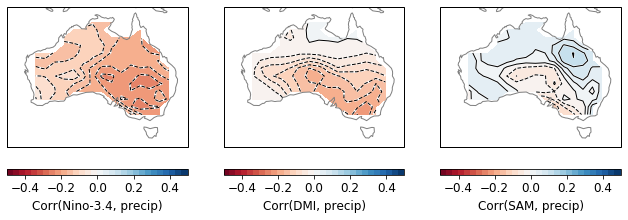

In [25]:
fields = [A_precip_nino34_AU.sel(lat=slice(-45.5,-7.5), lon=slice(108,158.5)),
          A_precip_dmi_AU.sel(lat=slice(-45.5,-7.5), lon=slice(108,158.5)), 
          A_precip_sam_AU.sel(lat=slice(-45.5,-7.5), lon=slice(108,158.5))]
vlim = (-0.5,0.5)
clim = (-0.5,0.5)
doppyo.sugar.plot_fields(fields, headings=['Corr(Nino-3.4, precip)', 'Corr(DMI, precip)', 'Corr(SAM, precip)'], 
                         ncol=3, ncontour=31, vlims=[vlim, vlim, vlim], clims=[clim, clim, clim],
                         cmaps=['RdBu','RdBu','RdBu'])

# Output to netcdf for Carly

In [39]:
Acorr = A_precip_nino34.rename('ENSO-precip').to_dataset()
Acorr['IOD-precip'] = A_precip_dmi
Acorr['SAM-precip'] = A_precip_sam
Acorr.to_netcdf('c2b_teleconnections.nc')

Acorr_land = A_precip_nino34_land.rename('ENSO-precip').to_dataset()
Acorr_land['IOD-precip'] = A_precip_dmi_land
Acorr_land['SAM-precip'] = A_precip_sam_land
Acorr_land.to_netcdf('c2b_teleconnections_land.nc')

Acorr_AU = A_precip_nino34_AU.rename('ENSO-precip').to_dataset()
Acorr_AU['IOD-precip'] = A_precip_dmi_AU
Acorr_AU['SAM-precip'] = A_precip_sam_AU
Acorr_AU.to_netcdf('c2b_teleconnections_AU.nc')